# A tutorial on retrieving data conditionally on UP42

## Introduction

This is a tutorial on how to retrieve data conditionally using [UP42](https://up42.com). On this tutorial we deal with satellite imagery data, but the described procedure is apllicable to **any** type of data.
The tutorial, in the form of this Jupyter notebook, relies on the [UP42 Python SDK](https://github.com/up42/up42-py). This SDK enables to quickly create an integration with the UP42 API using Python.
For further information on using UP42 in general, and the API in particular, please consult the [documentation](https://docs.up42.com).

It assumes you have an account with UP42 and are minimally familiar with the concepts and terminology used in UP42. 
If you don't have an account, please go and [create](https://console.up42.com/sign-up) one. Is completely free and additionally you get some free [credits](https://docs.up42.com/FAQ/pricing.html?highlight=credits#what-is-an-up42-credit) to try out UP42 by yourself.

## Problem statement

We want to search for existing data and check the search results against a _list_ of previously acquired data &mdash; satellite images. This list can be in any format deemed convenient: CSV, key-value store, relational database, etc.
For the sake of simplicity here we use a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file. CSV files are simple and portable across diverse operating systems. I also makes this tutorial simpler to follow
and reproduce all the steps by yourself. On the other hand CSV files lack anything remotely similar to [SQL](https://en.wikipedia.org/wiki/SQL), which makes the querying of data much simpler than relying on [Pandas](https://pandas.pydata.org/).
The advice we can give you is to use CSV if you are familiar with Pandas and/or you image list is not very large. 
If not, or if you have a very large image list, then something like [SQLite](https://en.wikipedia.org/wiki/SQLite) is more appropriate and allows to easily query the image list data set using SQL statements.

## Install the Python SDK
The module is called `up42`. Python **>= 3.7** is **required**.

 1. Create a virtual environment.
```bash
 mkvirtualenv --python=$(which python3) up42-py
```
 2. Activate the environment.
```bash
 workon up42-py
```
 3. Install the module.
 ```bash
 pip install up42-py
 ```
 4. Install Jupyter Lab.
```bash
 pip install jupyterlab
 ```
 5. Done.
 
Now we can just import it.

In [1]:
import up42

## Authenticate with project ID and project key
The project API key and the project ID are read from a JSON file.
This file has the following structure:

```json
{
  "project_id": "<your-project-ID-here>",
  "project_api_key": "<your-api-key-here>"
}
```
To know how to obtain the project API key and project ID the please refer to the [documentation](https://docs.up42.com/getting-started/first-api-request.html#run-your-first-job-via-the-api).

In [2]:
# Reading the credentials from myconfig.json.
project_config_file = "myconfig.json" 
up42.authenticate(cfg_file = project_config_file)

2020-06-16 17:06:37,863 - up42.auth - INFO - Got credentials from config file.
2020-06-16 17:06:38,103 - up42.auth - INFO - Authentication with UP42 successful!


## Initialize the project

In [3]:
project = up42.initialize_project()

2020-06-16 17:06:38,115 - up42 - INFO - Working on Project with project_id c8e817fe-767d-43f3-83bb-3644ea97e4cd


9## Get to see all the available blocks

In [4]:
all_blocks = up42.get_blocks(basic = True)

2020-06-16 17:06:40,022 - up42.tools - INFO - Getting blocks name and id, use basic=False for all block details.


In [5]:
all_blocks

{'oneatlas-spot-aoiclipped': '045019bb-06fc-4fa1-b703-318725b4d8af',
 'tiling': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff',
 'sobloo-s2-l1c-fullscene': '98c1acfa-c141-4095-b2e6-acf52d110178',
 'oneatlas-pleiades-aoiclipped': '18d09f1a-3197-4c27-a15a-54d099c31435',
 'sobloo-s1-grd-fullscene': 'b623400c-c5ac-40af-bda2-0d2734aa9dd1',
 'snap-polarimetric': '8c6baae9-d50e-406c-b4ac-e211caa6229d',
 'spacemetric-cloud-mask': '05796180-75ea-4194-a836-7bd2325457cc',
 'stops-itoworld': 'bab72a1d-c95a-4c42-8cdb-3d915198002a',
 'aiads_rgb_t3': '4123fe57-3b79-4b74-a6ef-f7bb9d08e028',
 'farearth/up42/house-detection': 'a09e65e0-4c57-415e-8a33-969a287d89af',
 'ship-detection': '79e3e48c-d65f-4528-a6d4-e8d20fecc93c',
 'sentinelhub-s2-aoiclipped': '018dfb34-fc19-4334-8125-14fd7535f979',
 'wind_turbines': 'e924d32d-cafa-45bf-a260-5eb0d0295750',
 'storage_tank': 'e271b0f9-afc8-45db-9c2e-037101ce5b53',
 'sentinelhub-landsat8-aoiclipped': '95519b2d-09d7-4cd0-a321-4d6a46bef6c1',
 'coreg': '6c379120-9789-448c-8e

As you can see the returned object is a **dictionary**.

In [6]:
type(all_blocks)

dict

## Now you get to decide if you want to use a workflow you already have or create a new one
Here we are going to create a new one. Further down we make use of an existing workflow.

In [7]:
all_blocks["oneatlas-pleiades-aoiclipped"] # Here we selected the Pléiades AOI clipped (streaming) block

'18d09f1a-3197-4c27-a15a-54d099c31435'

### Building a workflow with just this block

In [8]:
my_tasks = ["oneatlas-pleiades-aoiclipped"] # a task corresponds to a block in the workflow

In [9]:
workflow = project.create_workflow(name = "A workflow to implement an image subscription feed")

2020-06-16 17:06:40,460 - up42.project - INFO - Created new workflow: 0b64eb55-3dae-47f1-a39a-6f7cc59ecd89.


In [10]:
workflow.add_workflow_tasks(input_tasks = my_tasks)

2020-06-16 17:06:42,926 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'oneatlas-pleiades-aoiclipped:1', 'parentName': None, 'blockId': '18d09f1a-3197-4c27-a15a-54d099c31435'}]


#### Checking the workflow tasks

In [11]:
workflow.get_workflow_tasks(basic=True)

2020-06-16 17:06:43,276 - up42.workflow - INFO - Got 1 tasks/blocks in workflow 0b64eb55-3dae-47f1-a39a-6f7cc59ecd89.


{'oneatlas-pleiades-aoiclipped:1': 'd024bac0-0db4-4c6e-b41f-2b1407337ac7'}

## Let us input the AOI

The AOI needs to be in an **external** GeoJSOn file. There are multiple options to do this. One of them is using Google Maps.

 1. Draw the AOI in [geojson.io](http://geojson.io).
 2. Export as GeoJSON file.
 3. Done.

In [12]:
aoi = up42.read_vector_file("data/accra_location.geojson")

### Metadata from AOI GeoJSON as a an identifier
The GeoJSON specifying the AOI has a set of properties that identify this AOI in _human_ terms. Let us inspect it:

In [13]:
aoi_metadata = [feature["properties"] for feature in aoi["features"]]
aoi_metadata[0]

{'description': 'Some decription\\nabout this AOI here',
 'name': 'An AOI around Accra in Ghana',
 'uuid': '5430a572-aa95-11ea-9b0e-535d06e26317'}

We can see that there is an [UUID](https://en.wikipedia.org/wiki/Universally_unique_identifier#Version_4_(random)), a name and description. The UUID **uniquely** identifies this particular AOI.
We will see further down that this UUID is included in the record list for acquired images so far for this AOI. This list can have as many AOIs as desired. Since we are using a CSV this number must
be _reasonable_ since for very large number of images (records) and/or AOIs a key-value store or any other sort of database should be used.

## Create the job parameters

In [14]:
job_params = workflow.construct_parameters(geometry=aoi, geometry_operation = "intersects", limit=2) # I would like to have two images

### Let us check the job parameters

In [15]:
job_params

{'oneatlas-pleiades-aoiclipped:1': {'time': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00',
  'limit': 2,
  'zoom_level': 18,
  'max_cloud_cover': 100,
  'panchromatic_band': False,
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.1702880859375, 5.564646918068569),
     (-0.1684856414794922, 5.566013735754491),
     (-0.16788482666015625, 5.564134360617303),
     (-0.1702880859375, 5.564646918068569)),)}}}

## Run a test query to see what imagery is available

In [16]:
test_query_job = workflow.test_job(input_parameters = job_params, track_status = True)

2020-06-16 17:06:43,720 - up42.workflow - INFO - +++++++++++++++++++++++++++++++++
2020-06-16 17:06:43,725 - up42.workflow - INFO - Running this job as Test Query...
2020-06-16 17:06:43,729 - up42.workflow - INFO - +++++++++++++++++++++++++++++++++
2020-06-16 17:06:43,731 - up42.workflow - INFO - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'time': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00', 'limit': 2, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'intersects': {'type': 'Polygon', 'coordinates': (((-0.1702880859375, 5.564646918068569), (-0.1684856414794922, 5.566013735754491), (-0.16788482666015625, 5.564134360617303), (-0.1702880859375, 5.564646918068569)),)}}, 'config': {'mode': 'DRY_RUN'}}.
2020-06-16 17:06:44,473 - up42.workflow - INFO - Created and running new job: 4dfabbb7-3bea-4487-99fc-d0b6d4029115.
2020-06-16 17:06:44,766 - up42.job - INFO - Tracking job status continuously, reporting every 30 seconds...
2020-06-16 17:07:00

### Lets get the results
In this case the results is a GeoJSON that includes the metadata about the available imagery.
This is a `FeatureCollection` that will be empty if no imagery is found.

In [17]:
test_query_results = test_query_job.get_jobtasks_results_json()

2020-06-16 17:07:05,975 - up42.job - INFO - Getting job tasks: 4dfabbb7-3bea-4487-99fc-d0b6d4029115


In [18]:
# Get the top level key.
tq_key = list(test_query_results.keys())[0]

In [19]:
"Total of #: {} features found.".format(len(test_query_results[tq_key]))

'Total of #: 2 features found.'

In [20]:
## Get the properties of the found features.
props = [feature["properties"] for feature in test_query_results[tq_key]["features"]]

### Lets get the image IDs

In [21]:
# Fist let us look at the keys.
props[0]

{'acquisitionDate': '2019-05-08T10:33:19.555Z',
 'acquisitionIdentifier': 'DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786',
 'acquisitionStation': 'SV1',
 'archivingCenter': 'FR1',
 'azimuthAngle': 180.0467708844346,
 'cloudCover': 1.7,
 'commercialReference': 'SO19015177',
 'constellation': 'PHR',
 'correlationId': '7f7303cb-e898-4caa-b819-ea11f6b9a71b',
 'dataUri': 'gs://tcifg-idp-prod-datastore-data-pilot-nearline/PDWPHR_20190509080002_39_SO19015177-39-01_DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786.zip',
 'expirationDate': '2020-05-08T11:32:40.447119302Z',
 'format': 'image/jp2',
 'id': '75b55300-5861-43fc-8b2f-84873032d2bf',
 'illuminationAzimuthAngle': 59.06441937652318,
 'illuminationElevationAngle': 66.41793920664338,
 'incidenceAngle': 13.57639548099046,
 'incidenceAngleAcrossTrack': 1.527527306916784,
 'incidenceAngleAlongTrack': 13.49641327833666,
 'lastUpdateDate': '2019-05-09T11:32:40.447119302Z',
 'organisationName': 'AIRBUS DS GEO',
 'parentIdentifier': 'DS_PHR

The key we are interested in is `parentIdentifier`.

In [22]:
## Get the scene IDs.
scene_ids = [feature_props["parentIdentifier"] for feature_props in props]

In [23]:
scene_ids 

['DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786',
 'DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693']

## Compare against existing IDs
This has to be done on your side. Be it with a CSV file, KV store, relational DB, etc.
In this case we opt for using a simple [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file to hold a table of AOIs with acquired imagery and a description of the AOI. 

In [24]:
# Import pandas.
import pandas as pd 

### CSV file structure
The CSV file, `data/image_list.csv` has the following content:

| acquisitionDate      | scene_id                                                     |
|----------------------|--------------------------------------------------------------|
| 2020-04-13T10:05:49Z | S2B_MSIL1C_20200413T100549_N0209_R022_T30NZM_20200413T134946 |
| 2020-04-03T10:05:49Z | S2B_MSIL1C_20200403T100549_N0209_R022_T30NZM_20200403T135413 |
| 2020-03-29T10:10:21Z | S2A_MSIL1C_20200329T101021_N0209_R022_T30NZM_20200329T121428 |
| 2020-03-22T10:20:21Z | S2A_MSIL1C_20200322T102021_N0209_R065_T30NZM_20200322T122409 |
| 2020-03-12T10:20:21Z | S2A_MSIL1C_20200312T102021_N0209_R065_T30NZM_20200312T123419 |
| 2020-03-09T10:10:21Z | S2A_MSIL1C_20200309T101021_N0209_R022_T30NZM_20200309T122556 |
| 2020-02-28T10:10:21Z | S2A_MSIL1C_20200228T101021_N0209_R022_T30NZM_20200228T111325 |
| 2020-02-23T10:09:19Z | S2B_MSIL1C_20200223T100919_N0209_R022_T30NZM_20200223T130018 |
| 2020-02-21T10:20:41Z | S2A_MSIL1C_20200221T102041_N0209_R065_T30NZM_20200221T121341 |
| 2019-11-26T10:04:00Z | DS_SPOT6_201911261004001_FR1_FR1_FR1_FR1_E000N06_03089       |
| 2019-05-08T10:33:19Z | DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786           |

As you can see there are two fields: `acquisitionDate` and `scene_id`. The names are self-explanatory.

### Let us read the file and compare the existing scenes with the ones returned

We saw above that the scenes `DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786` and `DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693` are the ones returned by the test query.

In [25]:
# Read the image list from the CSV file.
image_list_file = "data/image_list.csv"
existing_scenes = pd.read_csv(image_list_file)

In [26]:
# Convert to a list.
existing_scenes=existing_scenes.scene_id.to_list()

Let us compare with a scene IDs returned from the test query and return all that are not yet in the CSV file.

In [27]:
scenes_to_retrieve = [i for i in scene_ids if i not in existing_scenes]

In [28]:
scenes_to_retrieve

['DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786',
 'DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693']

We see that **none** of the scenes from the test are on the list.

## We decided to acquire **both** scenes
We need to inject `scene_ids` into `job_parameters`. We just invoke the `workflow.construct_parameters` function now providing the IDs in the `ids` JSON field, corresponding to the argument `scene_ids` in the function.

In [29]:
job_params = workflow.construct_parameters(geometry=aoi, geometry_operation = "intersects", scene_ids = scenes_to_retrieve)

In [30]:
job_params

{'oneatlas-pleiades-aoiclipped:1': {'limit': 2,
  'zoom_level': 18,
  'max_cloud_cover': 100,
  'panchromatic_band': False,
  'ids': ['DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786',
   'DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.1702880859375, 5.564646918068569),
     (-0.1684856414794922, 5.566013735754491),
     (-0.16788482666015625, 5.564134360617303),
     (-0.1702880859375, 5.564646918068569)),)}}}

### Run the _real_ job with the parameters

In [31]:
real_job = workflow.run_job(input_parameters = job_params, track_status = True)

2020-06-16 17:07:07,587 - up42.workflow - INFO - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'limit': 2, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786', 'DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693'], 'intersects': {'type': 'Polygon', 'coordinates': (((-0.1702880859375, 5.564646918068569), (-0.1684856414794922, 5.566013735754491), (-0.16788482666015625, 5.564134360617303), (-0.1702880859375, 5.564646918068569)),)}}}.
2020-06-16 17:07:08,304 - up42.workflow - INFO - Created and running new job: 14d21147-47e7-422b-8ac1-609ae2b68da7.
2020-06-16 17:07:08,596 - up42.job - INFO - Tracking job status continuously, reporting every 30 seconds...
2020-06-16 17:07:24,779 - up42.job - INFO - Job finished successfully! - 14d21147-47e7-422b-8ac1-609ae2b68da7


## Download the results
First we create the directory where the output files will be written and then we write the files.

In [32]:
# Output directory.
my_path="/tmp/my-results"
from pathlib import Path
Path(my_path).mkdir(parents=True, exist_ok=True)

In [33]:
# Download the results into the output directory.
outfile = real_job.download_results(output_directory = my_path)

2020-06-16 17:07:29,808 - up42.job - INFO - Downloading results of job 14d21147-47e7-422b-8ac1-609ae2b68da7
2020-06-16 17:07:29,810 - up42.job - INFO - Download directory: /tmp/my-results
1303it [00:00, 200711.67it/s]
2020-06-16 17:07:30,654 - up42.utils - INFO - Download successful of 4 files to output_directory '/tmp/my-results': ['d801e575-d23c-4b2a-8027-39706c81a680.tif', 'data.json', 'ee608dae-ac96-4094-8374-42b9b095e595.tif', 'usage.json']


### Let us look inside the directory where we wrote the output

In [34]:
%%bash
ls -laR /tmp/my-results

total 4136
drwxr-xr-x   6 appa  wheel      192 Jun 16 17:07 .
drwxrwxrwt  14 root  wheel      448 Jun 16 17:07 ..
-rw-r--r--   1 appa  wheel  1049991 Jun 16 17:07 d801e575-d23c-4b2a-8027-39706c81a680.tif
-rw-r--r--   1 appa  wheel     4508 Jun 16 17:07 data.json
-rw-r--r--   1 appa  wheel  1049991 Jun 16 17:07 ee608dae-ac96-4094-8374-42b9b095e595.tif
-rw-r--r--   1 appa  wheel      265 Jun 16 17:07 usage.json


## Visualize the results
We reference the `real_job` variable.

In [35]:
# First we get the GeoTIFF image(s) filename(s).
import glob
img_files = [f for f in glob.glob(my_path + "/*.tif")]

In [36]:
img_files

['/tmp/my-results/ee608dae-ac96-4094-8374-42b9b095e595.tif',
 '/tmp/my-results/d801e575-d23c-4b2a-8027-39706c81a680.tif']

In [37]:
real_job.download_quicklooks(output_directory="/tmp/my-results")

2020-06-16 17:07:31,371 - up42.jobtask - INFO - Download directory: /tmp/my-results
100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


['/tmp/my-results/quicklook_d801e575-d23c-4b2a-8027-39706c81a680.jpeg',
 '/tmp/my-results/quicklook_ee608dae-ac96-4094-8374-42b9b095e595.jpeg']

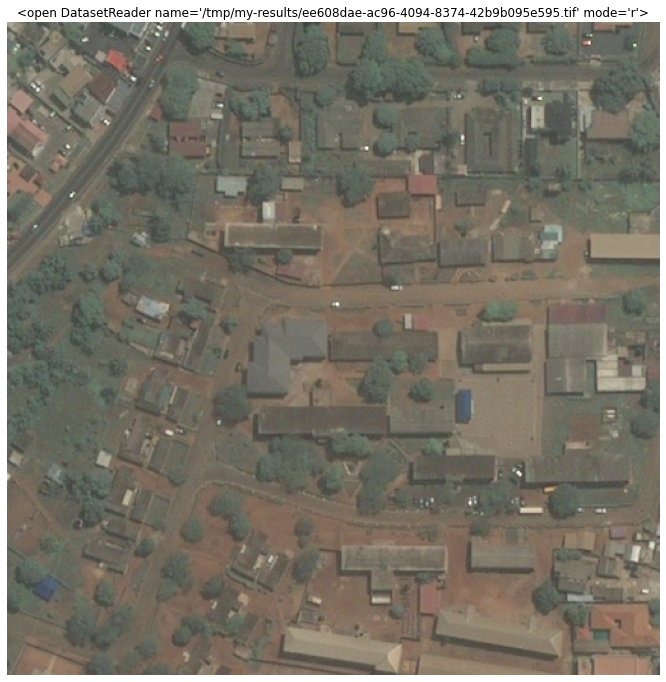

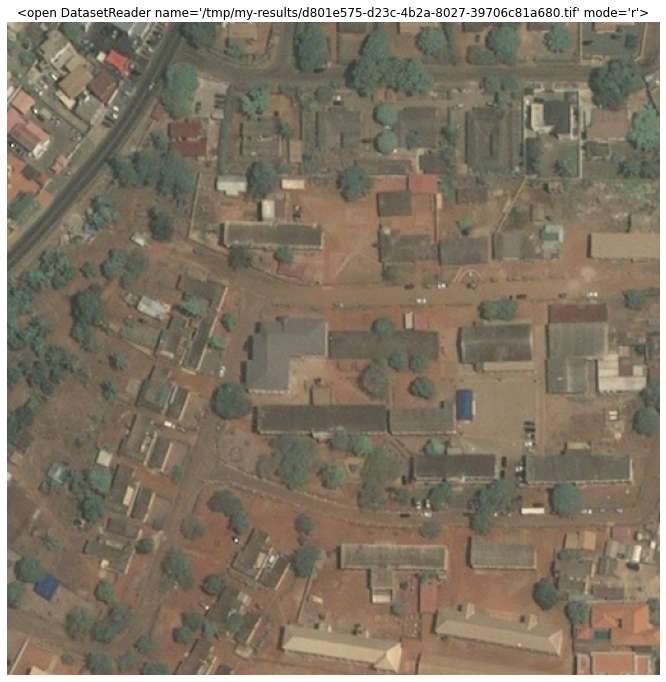

In [38]:
# Now we plot the image files.
from rasterio import open, plot
# Set the size and style the image.
import matplotlib.pyplot as plt
[plt.figure(figsize=(12,12)) and plt.title(s) and plt.axis("off") and plot.show(s) for s in [open(f) for f in img_files]];

## Visualize the quicklooks
Quicklooks are low quality bitmap images, usually in JPEG or PNG format that provide a preview of the original images.

In [39]:
quicklooks = real_job.download_quicklooks(output_directory=my_path)

2020-06-16 17:07:34,417 - up42.jobtask - INFO - Download directory: /tmp/my-results
100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


In [40]:
quicklooks

['/tmp/my-results/quicklook_d801e575-d23c-4b2a-8027-39706c81a680.jpeg',
 '/tmp/my-results/quicklook_ee608dae-ac96-4094-8374-42b9b095e595.jpeg']

/Users/appa/.virtualenvs/up42-py/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


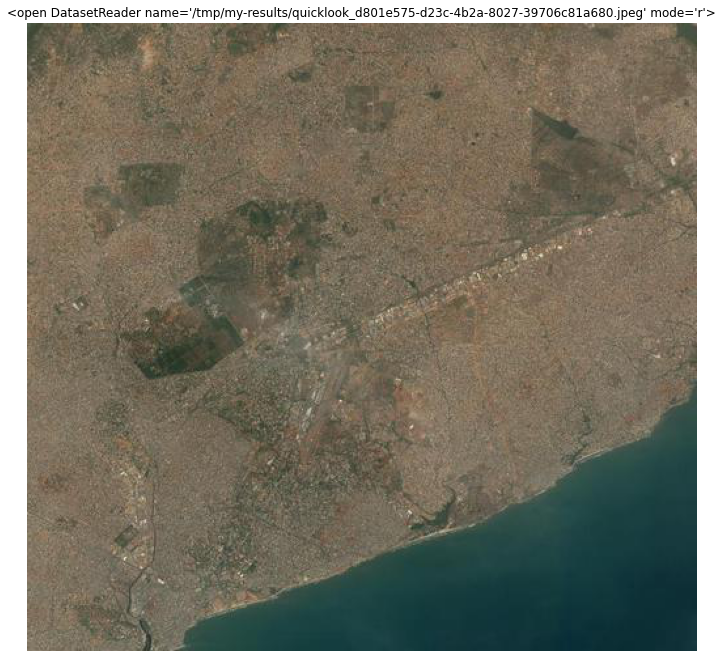

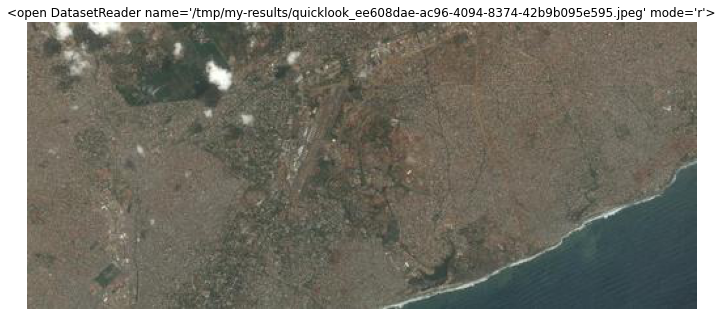

In [41]:
[plt.figure(figsize=(12,12)) and plt.title(s) and plt.axis("off") and plot.show(s) for s in [open(f) for f in quicklooks]];

## Adding the retrieved scenes to the image list
Now that we have retrieved the two scenes from Pléaides we can add them to the CSV file that has all the retrieved images so far. We need to go back to the GeoJSON returned in test query and obtain the acquisition dates.

In [42]:
## Get the scene and aqcuisition dates pairs.
retrieved_image_list = [[feature_props["acquisitionDate"], feature_props["parentIdentifier"]] for feature_props in props]

In [43]:
retrieved_image_list

[['2019-05-08T10:33:19.555Z',
  'DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786'],
 ['2019-02-26T10:29:40.18Z',
  'DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693']]

In [44]:
# Create a data frame to hold the retrueve images.
scenes_to_add = pd.DataFrame(retrieved_image_list, columns=["acquisitionDate", "scene_id"])

In [45]:
scenes_to_add

acquisitionDate                                           scene_id
0  2019-05-08T10:33:19.555Z  DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_0...
1   2019-02-26T10:29:40.18Z  DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_0...

In [46]:
# Append it to the image list CSV file.
scenes_to_add.to_csv(image_list_file, mode="a", index=False, header=False)

We can use the UNIX utility `tail` to peek inside the CSV file. To confirm that the images we retrieved above are now added.

In [47]:
%%bash
tail -2 data/image_list.csv

2019-05-08T10:33:19.555Z,DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_00786
2019-02-26T10:29:40.18Z,DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_01693


## Using catalog search
Catalog search is a functionality that allows to search across multiple data sources simultaneously. [Above](#Run-a-test-query-to-see-what-imagery-is-available) we used a test query. This can, currently, only search across a single data source.
Catalog search uses a different API endpoints and accepts as payload a [STAC](https://stacspec.org/STAC-api.html#tag/STAC) query.
### Create an instance of the catalog object (initialize catalog search)
Please note that we already [authenticated](#Authenticate-with-project-ID-and-project-key) above.

In [48]:
catalog = up42.initialize_catalog()

### Create the search parameters (STAC query)

 We can set the following parameters for the search:  
 
 1. The are of interest, [AOI](#Let-us-input-the-AOI): `aoi`.
 
 2. start (`start_date`) and end date (`end_date`) (defining the date range). Default value is between January 1st and December 31st of the current year.
 
 3. What satellites (data sources) are we searching through. Possible values are:
    + pleiades
    + spot
    + sentinel1
    + sentinel2
    + sentinel3
    + sentinel5p
    
    This corresponds to the `sensors` parameter &mdash; a list. By default it searches across **all** of them.
 
 4. Define how many results we want: `limit` parameter.
 
 5. cloud coverage: `max_cloudcover` parameter.
 
 6. Result sorting key. The results can be sorted by &mdash; `sortby`parameter:
    + cloud coverage: cloudCoverage (default).
    + acquisition date: acquisitionDate`.
    + scene ID: acquisitionIdentifier.
    + incidence angle: incidenceAngle`.
    + snow coverage: snowCover.

 7. Ordering of results. In which direction the results are ordered. This corresponds to the parameter `ascending`. By default it `True`.  
 
 
In this case we are looking for Pléiades, SPOT and Sentinel 2 data for this AOI from Januray 1st 2019 until now, and we want the data to be sorted by descending order of the acquisition date, i.e, 
most recent results displayed first. We want a maximum cloud coverage of 20%.

In [49]:
search_params = catalog.construct_parameters(geometry=aoi, start_date="2019-01-01", end_date="2020-12-31", sortby="acquisitionDate", ascending=False, max_cloudcover=20, sensors=["pleiades","spot","sentinel2"], limit=100)

In [50]:
search_params

{'datetime': '2019-01-01T00:00:00Z/2020-12-31T00:00:00Z',
 'intersects': {'type': 'Polygon',
  'coordinates': (((-0.1702880859375, 5.564646918068569),
    (-0.1684856414794922, 5.566013735754491),
    (-0.16788482666015625, 5.564134360617303),
    (-0.1702880859375, 5.564646918068569)),)},
 'limit': 100,
 'query': {'cloudCoverage': {'lte': 20},
  'dataBlock': {'in': ['oneatlas-pleiades-fullscene',
    'oneatlas-pleiades-aoiclipped',
    'oneatlas-spot-fullscene',
    'oneatlas-spot-aoiclipped',
    'sobloo-sentinel2-lic-msi-full',
    'sobloo-sentinel2-lic-msi-aoiclipped']}},
 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}

### Perform the search

In [51]:
search_results = catalog.search(search_parameters=search_params)

2020-06-16 17:07:36,546 - up42.catalog - INFO - Searching catalog with: {'datetime': '2019-01-01T00:00:00Z/2020-12-31T00:00:00Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-0.1702880859375, 5.564646918068569), (-0.1684856414794922, 5.566013735754491), (-0.16788482666015625, 5.564134360617303), (-0.1702880859375, 5.564646918068569)),)}, 'limit': 100, 'query': {'cloudCoverage': {'lte': 20}, 'dataBlock': {'in': ['oneatlas-pleiades-fullscene', 'oneatlas-pleiades-aoiclipped', 'oneatlas-spot-fullscene', 'oneatlas-spot-aoiclipped', 'sobloo-sentinel2-lic-msi-full', 'sobloo-sentinel2-lic-msi-aoiclipped']}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}
2020-06-16 17:07:37,793 - up42.catalog - INFO - 54 results returned.


In [52]:
search_results

index                                           geometry  \
0       1  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
1       2  POLYGON ((-0.21289 5.33337, -0.20380 5.37400, ...   
2       3  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
3       4  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
4       5  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
5       6  POLYGON ((-0.21789 5.33340, -0.19731 5.42551, ...   
6       7  POLYGON ((-0.21680 5.33339, -0.20056 5.40609, ...   
7       8  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
8       9  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
9      10  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
10     11  POLYGON ((-0.21231 5.33337, -0.19278 5.42051, ...   
11     12  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
12     13  POLYGON ((-0.21494 5.33338, -0.19571 5.41927, ...   
13     14  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
14     15  POLYGON ((-0.21030 5.33336, -0.18854 5.43060, ...   
15     16  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
16     17  POLYGON ((-0.21313 5.33337, -0.18036 5.48013, ...   
17     18  POLYGON ((-0.21066 5.33336, -0.19955 5.38300, ...   
18     19  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
19     20  POLYGON ((-0.21124 5.33336, -0.18573 5.44511, ...   
20     21  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
21     22  POLYGON ((-0.21463 5.33338, -0.19308 5.42989, ...   
22     23  POLYGON ((-0.21274 5.33337, -0.20779 5.35551, ...   
23     24  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
24     25  POLYGON ((-0.21570 5.33338, -0.20212 5.39419, ...   
25     26  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
26     27  POLYGON ((-0.21265 5.33337, -0.18964 5.43665, ...   
27     28  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
28     29  POLYGON ((-0.21530 5.33338, -0.21078 5.35323, ...   
29     30  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
30     31  POLYGON ((-0.21167 5.33336, -0.20193 5.37687, ...   
31     32  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
32     33  POLYGON ((-0.21613 5.33339, -0.19119 5.44473, ...   
33     34  POLYGON ((-0.21484 5.33338, -0.20404 5.38205, ...   
34     35  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
35     36  POLYGON ((-0.21265 5.33337, -0.20227 5.37971, ...   
36     37  POLYGON ((-0.22168 5.33341, -0.19385 5.45721, ...   
37     38  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
38     39  POLYGON ((-0.28745 6.37807, -0.28493 5.35335, ...   
39     41  POLYGON ((-0.21713 5.33339, -0.19409 5.43657, ...   
40     42  POLYGON ((-0.21942 5.33340, -0.21310 5.36113, ...   
41     43  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
42     44  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
43     45  POLYGON ((-0.24808 5.63861, -0.06349 5.63735, ...   
44     46  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
45     48  POLYGON ((-0.22076 5.33341, -0.18884 5.47601, ...   
46     49  POLYGON ((-0.29087 5.88224, -0.29351 5.33379, ...   
47     50  POLYGON ((0.00623 6.32414, -0.28874 6.32596, -...   
48     51  POLYGON ((-0.25504 5.72535, -0.05977 5.71365, ...   
49     52  POLYGON ((0.00266 6.32416, -0.28876 6.32596, -...   
50     53  POLYGON ((-0.25147 5.87755, -0.06380 5.88245, ...   

                                      id       acquisitionDate constellation  \
0   3539a230-7157-4136-a4ba-86e8c9d3d006  2020-05-08T10:10:31Z    Sentinel-2   
1   0bd9c097-3787-4fe4-bd42-b17d955362be  2020-04-16T10:15:49Z    Sentinel-2   
2   9bf8db17-899b-4819-b315-6892dc744014  2020-04-13T10:05:49Z    Sentinel-2   
3   09175956-ff5f-4336-88ad-49169bd03dbc  2020-04-03T10:05:49Z    Sentinel-2   
4   b6117752-ece9-4c3e-a390-c3f5d60c2ffd  2020-03-29T10:10:21Z    Sentinel-2   
5   8002ec6c-fd2d-40c2-8a4f-bc3d83f5e214  2020-03-22T10:20:21Z    Sentinel-2   
6   515a0de3-b318-4f89-b0fe-d0dfe09f20a9  2020-03-12T10:20:21Z    Sentinel-2   
7   d8b0a927-4889-4d6b-a63b-83f625b

In [53]:
search_results.head()

index                                           geometry  \
0      1  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
1      2  POLYGON ((-0.21289 5.33337, -0.20380 5.37400, ...   
2      3  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
3      4  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
4      5  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   

                                     id       acquisitionDate constellation  \
0  3539a230-7157-4136-a4ba-86e8c9d3d006  2020-05-08T10:10:31Z    Sentinel-2   
1  0bd9c097-3787-4fe4-bd42-b17d955362be  2020-04-16T10:15:49Z    Sentinel-2   
2  9bf8db17-899b-4819-b315-6892dc744014  2020-04-13T10:05:49Z    Sentinel-2   
3  09175956-ff5f-4336-88ad-49169bd03dbc  2020-04-03T10:05:49Z    Sentinel-2   
4  b6117752-ece9-4c3e-a390-c3f5d60c2ffd  2020-03-29T10:10:21Z    Sentinel-2   

   providerName                                         blockNames  \
0  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
1  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
2  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
3  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
4  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   

   cloudCoverage                                 providerProperties  \
0        12.5056  {'timeStamp': 1588932631024, 'uid': '3539a230-...   
1         7.9165  {'timeStamp': 1587032149024, 'uid': '0bd9c097-...   
2         6.7392  {'timeStamp': 1586772349024, 'uid': '9bf8db17-...   
3        11.4301  {'timeStamp': 1585908349024, 'uid': '09175956-...   
4         4.3522  {'timeStamp': 1585476621024, 'uid': 'b6117752-...   

                                            scene_id  
0  S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_2...  
1  S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_2...  
2  S2B_MSIL1C_20200413T100549_N0209_R022_T30NZM_2...  
3  S2B_MSIL1C_20200403T100549_N0209_R022_T30NZM_2...  
4  S2A_MSIL1C_20200329T101021_N0209_R022_T30NZM_2...

### Compare with the existing images
Like we did before we are going to compare with the existing list. We are going to check separately for Sentinel 2, Pléaides and SPOT, since each correspond to different data blocks, hence different data acquisition workflows.
The different satellites are listed in the column `constellation`.

In [54]:
# Pléaides results (PHR).
pleiades_results = search_results[search_results.constellation == "PHR"]

In [55]:
# SPOT results.
spot_results = search_results[search_results.constellation == "SPOT"]

In [56]:
# Sentinel 2 results.
sentinel2_results = search_results[search_results.constellation == "Sentinel-2"]

In [57]:
image_list = pd.read_csv(image_list_file)

Now we see if any of the search results for Pléaides are in the image list. 

In [58]:
image_list[image_list["scene_id"].isin(pleiades_results["scene_id"])]

acquisitionDate  \
10      2019-01-11T10:32:59Z   
11  2019-05-08T10:33:19.555Z   
12   2019-02-26T10:29:40.18Z   

                                             scene_id  
10  DS_PHR1B_201901111032590_FR1_PX_W001N05_1117_0...  
11  DS_PHR1A_201905081033195_FR1_PX_W001N05_1115_0...  
12  DS_PHR1A_201902261029401_FR1_PX_W001N05_1115_0...

In [59]:
len(pleiades_results)

3

We see that **all** returned search results for Pléaides **are** in the image list. Therefore there is nothing new to retrieve.
Now we do the same for SPOT and Sentinel 2.

In [60]:
image_list[image_list["scene_id"].isin(spot_results["scene_id"])]

acquisitionDate                                           scene_id
9  2019-11-26T10:04:00Z  DS_SPOT6_201911261004001_FR1_FR1_FR1_FR1_E000N...

In [61]:
len(spot_results)

1

In [62]:
existing_sentinel2 = image_list[image_list["scene_id"].isin(sentinel2_results["scene_id"])]

In [63]:
existing_sentinel2

acquisitionDate                                           scene_id
0  2020-04-13T10:05:49Z  S2B_MSIL1C_20200413T100549_N0209_R022_T30NZM_2...
1  2020-04-03T10:05:49Z  S2B_MSIL1C_20200403T100549_N0209_R022_T30NZM_2...
2  2020-03-29T10:10:21Z  S2A_MSIL1C_20200329T101021_N0209_R022_T30NZM_2...
3  2020-03-22T10:20:21Z  S2A_MSIL1C_20200322T102021_N0209_R065_T30NZM_2...
4  2020-03-12T10:20:21Z  S2A_MSIL1C_20200312T102021_N0209_R065_T30NZM_2...
5  2020-03-09T10:10:21Z  S2A_MSIL1C_20200309T101021_N0209_R022_T30NZM_2...
6  2020-02-28T10:10:21Z  S2A_MSIL1C_20200228T101021_N0209_R022_T30NZM_2...
7  2020-02-23T10:09:19Z  S2B_MSIL1C_20200223T100919_N0209_R022_T30NZM_2...
8  2020-02-21T10:20:41Z  S2A_MSIL1C_20200221T102041_N0209_R065_T30NZM_2...

In [64]:
len(sentinel2_results) - len(existing_sentinel2)

38

There are 38 images returned by the search results that are **not** in the image list. However we are only interested in images **after February 21st, 2020**. 

In [65]:
# List the acquisition dates for Sentinel 2.
sentinel2_results[~sentinel2_results["scene_id"].isin(existing_sentinel2["scene_id"])].acquisitionDate

0     2020-05-08T10:10:31Z
1     2020-04-16T10:15:49Z
11    2020-02-18T10:10:51Z
12    2020-02-16T10:20:19Z
13    2020-02-13T10:10:29Z
14    2020-02-11T10:21:41Z
15    2020-02-08T10:11:51Z
16    2020-02-06T10:21:09Z
17    2020-02-01T10:22:41Z
18    2020-01-29T10:12:51Z
19    2020-01-27T10:22:09Z
20    2020-01-24T10:12:19Z
21    2020-01-17T10:22:49Z
22    2020-01-12T10:24:01Z
23    2020-01-09T10:14:01Z
24    2020-01-07T10:23:19Z
25    2020-01-04T10:13:19Z
26    2020-01-02T10:24:21Z
27    2019-12-30T10:14:21Z
28    2019-12-28T10:23:39Z
29    2019-12-25T10:13:29Z
30    2019-12-23T10:24:31Z
31    2019-12-20T10:14:31Z
32    2019-12-18T10:23:39Z
33    2019-12-13T10:24:21Z
34    2019-12-10T10:14:11Z
35    2019-12-08T10:23:19Z
36    2019-12-03T10:24:01Z
37    2019-11-30T10:14:01Z
39    2019-11-18T10:22:19Z
40    2019-10-29T10:20:39Z
41    2019-09-16T10:10:29Z
42    2019-08-12T10:10:31Z
44    2019-04-29T10:10:29Z
45    2019-03-28T10:20:21Z
46    2019-03-05T10:10:21Z
47    2019-03-03T10:20:19Z
4

These correspond to the first **two** rows.

In [66]:
non_existing_sentinel2 = sentinel2_results[~sentinel2_results["scene_id"].isin(existing_sentinel2["scene_id"])].iloc[:2]

In [67]:
non_existing_sentinel2

index                                           geometry  \
0      1  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
1      2  POLYGON ((-0.21289 5.33337, -0.20380 5.37400, ...   

                                     id       acquisitionDate constellation  \
0  3539a230-7157-4136-a4ba-86e8c9d3d006  2020-05-08T10:10:31Z    Sentinel-2   
1  0bd9c097-3787-4fe4-bd42-b17d955362be  2020-04-16T10:15:49Z    Sentinel-2   

   providerName                                         blockNames  \
0  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
1  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   

   cloudCoverage                                 providerProperties  \
0        12.5056  {'timeStamp': 1588932631024, 'uid': '3539a230-...   
1         7.9165  {'timeStamp': 1587032149024, 'uid': '0bd9c097-...   

                                            scene_id  
0  S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_2...  
1  S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_2...

Finally getting the scene IDs for Sentinel 2 that we will retrieve.

In [68]:
sentinel2_scene_ids = non_existing_sentinel2["scene_id"].to_list()

## Creating a job for a pre-existing workflow
We are going to use a workflow that was previously created. To be able to refer to a previously existing workflow we need the workflow ID.
To get that we look at the URL, e.g.: `https://console.up42.com/projects/c8e817fe-767d-43f3-83bb-3644ea97e4cd/workflows/5447e73a-6edc-466e-8d5b-ecae7da17c45`.
The workflow ID is the last component of the URL: `5447e73a-6edc-466e-8d5b-ecae7da17c45`. This can be obtained by, on the console, clicking on the **Manage With API** button
on the upper right corner. You can copy it to the clipboard.

In [69]:
sentinel2_workflow_id = "5447e73a-6edc-466e-8d5b-ecae7da17c45"

### Initialize the workflow

In [70]:
sentinel2_workflow = up42.initialize_workflow(workflow_id=sentinel2_workflow_id)

In [71]:
sentinel2_workflow

Workflow(workflow_id=5447e73a-6edc-466e-8d5b-ecae7da17c45, project_id=c8e817fe-767d-43f3-83bb-3644ea97e4cd, auth=UP42ProjectAuth(project_id=c8e817fe-767d-43f3-83bb-3644ea97e4cd, env=com), info={'id': '5447e73a-6edc-466e-8d5b-ecae7da17c45', 'name': 'S2 Full Scene + Superres', 'description': '', 'createdAt': '2020-06-10T16:21:19.442Z', 'updatedAt': '2020-06-12T20:36:55.915Z', 'totalProcessingTime': 2049})

In [72]:
type(sentinel2_workflow)

up42.workflow.Workflow

### List the workflow tasks
This workflow has **two** tasks, one for acquiring the [Sentinel 2 full scene](https://marketplace.up42.com/block/98c1acfa-c141-4095-b2e6-acf52d110178) and another one for applying the [super-resolution block](https://marketplace.up42.com/block/f6c29b0a-75bd-44a1-a040-f18c9e881d1d) in order to bring all bands to **10 m** resolution. 

In [73]:
sentinel2_workflow.get_workflow_tasks(basic = True)

2020-06-16 17:07:39,263 - up42.workflow - INFO - Got 2 tasks/blocks in workflow 5447e73a-6edc-466e-8d5b-ecae7da17c45.


{'sobloo-s2-l1c-fullscene:1': '164c3fd5-8b47-4576-afd0-55ac4c1b2dcd',
 's2-superresolution:1': 'e211d6d3-8453-4b9d-8c38-59deeafe8cdf'}

### Get the job parameters _template_
We need to find out what parameters are accepted by this workflow. It includes **all** the parameters for **each** block in the workflow.

In [74]:
sentinel2_workflow_params_info = sentinel2_workflow.get_parameters_info()

2020-06-16 17:07:39,738 - up42.workflow - INFO - Got 2 tasks/blocks in workflow 5447e73a-6edc-466e-8d5b-ecae7da17c45.


In [75]:
sentinel2_workflow_params_info

{'sobloo-s2-l1c-fullscene:1': {'ids': {'type': 'array', 'default': None},
  'bbox': {'type': 'array', 'default': None},
  'time': {'type': 'dateRange',
   'default': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00'},
  'limit': {'type': 'integer', 'default': 1, 'minimum': 1},
  'contains': {'type': 'geometry'},
  'intersects': {'type': 'geometry'},
  'time_series': {'type': 'array', 'default': None},
  'max_cloud_cover': {'type': 'integer',
   'default': 100,
   'maximum': 100,
   'minimum': 0}},
 's2-superresolution:1': {'bbox': {'type': 'array', 'default': None},
  'contains': {'type': 'geometry', 'default': None},
  'intersects': {'type': 'geometry', 'default': None},
  'clip_to_aoi': {'type': 'boolean', 'default': False},
  'copy_original_bands': {'type': 'boolean', 'default': True}}}

## Create the job parameters
Due to the fact that the Super-resolution block requires abn AOI with a minimum of $4\; km^2$ we cannot use the same AOI as above. We need an **enlarged** AOI. Although we can leave the same date range in place because the scene IDs determine which images are going to be retrieved.

### Data block job parameters
The job parameters for the data block can be given by arguments to `construct_parameters`. Let us read the enlarged AOI GeoJSON file first.

In [76]:
enlarged_aoi = up42.read_vector_file("data/accra_location_enlarged.geojson")

In [77]:
sentinel2_job_params = sentinel2_workflow.construct_parameters(geometry=enlarged_aoi, geometry_operation = "intersects", scene_ids=sentinel2_scene_ids)

In [78]:
sentinel2_job_params

{'sobloo-s2-l1c-fullscene:1': {'limit': 2,
  'max_cloud_cover': 100,
  'ids': ['S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_20200508T134553',
   'S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_20200416T131242'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.1828622817993164, 5.547091571263355),
     (-0.18723964691162162, 5.564710987718567),
     (-0.16724914312359979, 5.568987621068604),
     (-0.16033172607421875, 5.553498692765496),
     (-0.1828622817993164, 5.547091571263355)),)}},
 's2-superresolution:1': {'clip_to_aoi': False, 'copy_original_bands': True}}

### Processing blocks job parameters
Since it is not possible to foresee all the possible combinations of parameters for a processing block we must specifiy the parameters for the processing block **directly**.
By modifying the JSON (Python dictionary) `sentinal2_job_parameters`.

In [79]:
# Get the dictionary key first.
t_keys = list(sentinel2_workflow_params_info.keys())

In [80]:
t_keys

['sobloo-s2-l1c-fullscene:1', 's2-superresolution:1']

Is the second key we are interested in.

In [81]:
t2_key = t_keys[1]

In [82]:
t2_key

's2-superresolution:1'

Selecting the parameters for the Super-resolution block we have to go _back_ to the original parameter template. For a full explanation of the possible parameters please refer to the block [reference documentation](https://docs.up42.com/up42-blocks/processing/s2-superresolution.html).
Since we want to **clip** the image to be super-resolved to the original AOI we need to _inject_ the data block AOI specification into the Super-resolution block parameters and also set the `clip_to_aoi` parameter to `True`.

In [83]:
sentinel2_job_params[t2_key]["intersects"] = sentinel2_job_params[t_keys[0]]["intersects"]

In [84]:
sentinel2_job_params[t2_key]["clip_to_aoi"] = True

In [85]:
sentinel2_job_params

{'sobloo-s2-l1c-fullscene:1': {'limit': 2,
  'max_cloud_cover': 100,
  'ids': ['S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_20200508T134553',
   'S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_20200416T131242'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.1828622817993164, 5.547091571263355),
     (-0.18723964691162162, 5.564710987718567),
     (-0.16724914312359979, 5.568987621068604),
     (-0.16033172607421875, 5.553498692765496),
     (-0.1828622817993164, 5.547091571263355)),)}},
 's2-superresolution:1': {'clip_to_aoi': True,
  'copy_original_bands': True,
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.1828622817993164, 5.547091571263355),
     (-0.18723964691162162, 5.564710987718567),
     (-0.16724914312359979, 5.568987621068604),
     (-0.16033172607421875, 5.553498692765496),
     (-0.1828622817993164, 5.547091571263355)),)}}}

Now we have set **all** the parameters for **both** blocks.

## Run the job and retrieve the Sentinel 2 images
We are going to name the job so that is easier to find when going on the console.

In [86]:
sentinel2_job = sentinel2_workflow.run_job(input_parameters=sentinel2_job_params, name="Sentinel 2 missing images retrieval", track_status=True)

2020-06-16 17:07:40,404 - up42.workflow - INFO - Selected input_parameters: {'sobloo-s2-l1c-fullscene:1': {'limit': 2, 'max_cloud_cover': 100, 'ids': ['S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_20200508T134553', 'S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_20200416T131242'], 'intersects': {'type': 'Polygon', 'coordinates': (((-0.1828622817993164, 5.547091571263355), (-0.18723964691162162, 5.564710987718567), (-0.16724914312359979, 5.568987621068604), (-0.16033172607421875, 5.553498692765496), (-0.1828622817993164, 5.547091571263355)),)}}, 's2-superresolution:1': {'clip_to_aoi': True, 'copy_original_bands': True, 'intersects': {'type': 'Polygon', 'coordinates': (((-0.1828622817993164, 5.547091571263355), (-0.18723964691162162, 5.564710987718567), (-0.16724914312359979, 5.568987621068604), (-0.16033172607421875, 5.553498692765496), (-0.1828622817993164, 5.547091571263355)),)}}}.
2020-06-16 17:07:41,364 - up42.workflow - INFO - Created and running new job: c51391ec-f709-4043-87d4-c8bc

## Download the results
Now we download the **two** Sentinel 2 full scenes we retrieved.

In [87]:
my_sentinel2_path="/tmp/my-sentinel2-results"
Path(my_sentinel2_path).mkdir(parents=True, exist_ok=True)

In [88]:
sentinel2_job_results = sentinel2_job.download_results(output_directory=my_sentinel2_path)

2020-06-16 17:12:01,240 - up42.job - INFO - Downloading results of job c51391ec-f709-4043-87d4-c8bc5f941c80
2020-06-16 17:12:01,242 - up42.job - INFO - Download directory: /tmp/my-sentinel2-results
5287it [00:00, 344005.54it/s]
2020-06-16 17:12:02,992 - up42.utils - INFO - Download successful of 3 files to output_directory '/tmp/my-sentinel2-results': ['0bd9c097-3787-4fe4-bd42-b17d955362be_superresolution.tif', '3539a230-7157-4136-a4ba-86e8c9d3d006_superresolution.tif', 'data.json']


## Visualize the results
Looking inside the output directory.

In [89]:
%%bash
ls -laR /tmp/my-sentinel2-results

total 18464
drwxr-xr-x   5 appa  wheel      160 Jun 16 17:12 .
drwxrwxrwt  15 root  wheel      480 Jun 16 17:12 ..
-rw-r--r--   1 appa  wheel  4720094 Jun 16 17:12 0bd9c097-3787-4fe4-bd42-b17d955362be_superresolution.tif
-rw-r--r--   1 appa  wheel  4720094 Jun 16 17:12 3539a230-7157-4136-a4ba-86e8c9d3d006_superresolution.tif
-rw-r--r--   1 appa  wheel     4607 Jun 16 17:12 data.json


In [90]:
# First we get the GeoTIFF image(s) filename(s).
sentinel2_img_files = [f for f in glob.glob(my_sentinel2_path + "/*.tif")]

In [91]:
sentinel2_img_files

['/tmp/my-sentinel2-results/0bd9c097-3787-4fe4-bd42-b17d955362be_superresolution.tif',
 '/tmp/my-sentinel2-results/3539a230-7157-4136-a4ba-86e8c9d3d006_superresolution.tif']

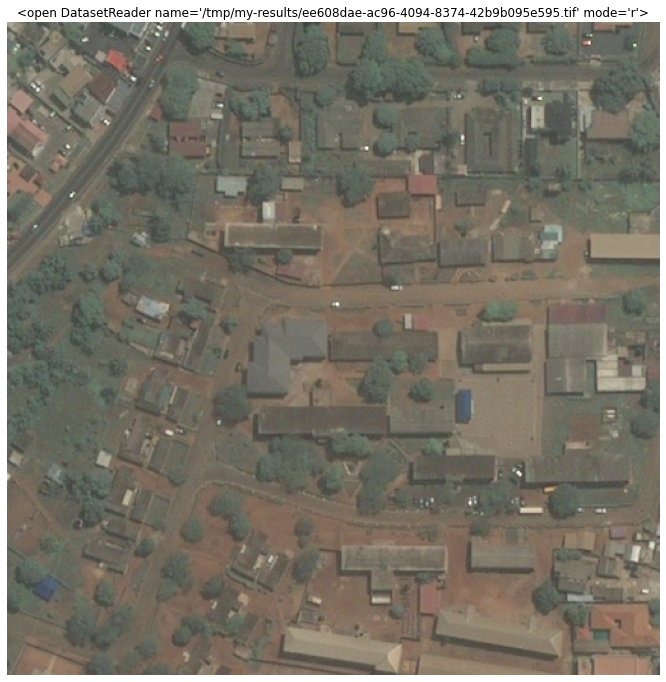

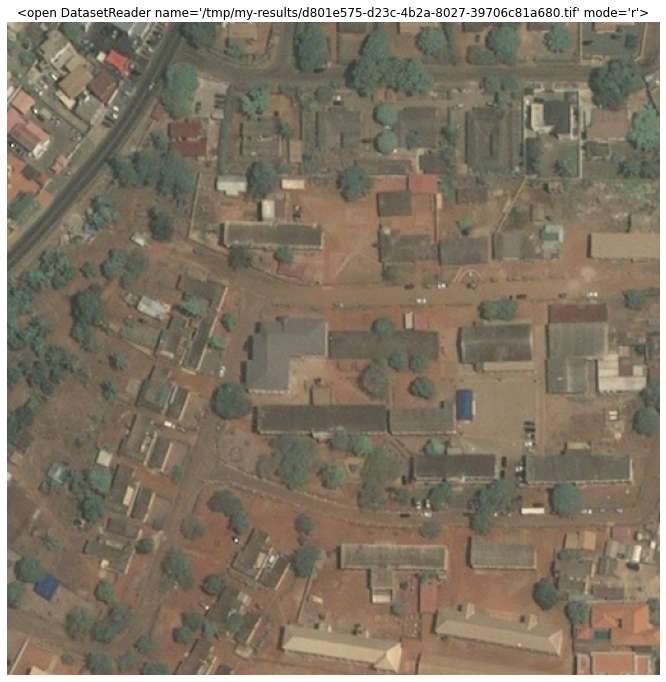

In [92]:
# Now we plot the image files.
[plt.figure(figsize=(12,12)) and plt.title(s) and plt.axis("off") and plot.show(s) for s in [open(f) for f in img_files]];

## Visualize the quicklooks

In [93]:
sentinel2_quicklooks = sentinel2_job.download_quicklooks(output_directory=my_sentinel2_path)

2020-06-16 17:12:05,413 - up42.jobtask - INFO - Download directory: /tmp/my-sentinel2-results
100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


In [94]:
sentinel2_quicklooks

['/tmp/my-sentinel2-results/quicklook_0bd9c097-3787-4fe4-bd42-b17d955362be.png',
 '/tmp/my-sentinel2-results/quicklook_3539a230-7157-4136-a4ba-86e8c9d3d006.png']

/Users/appa/.virtualenvs/up42-py/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


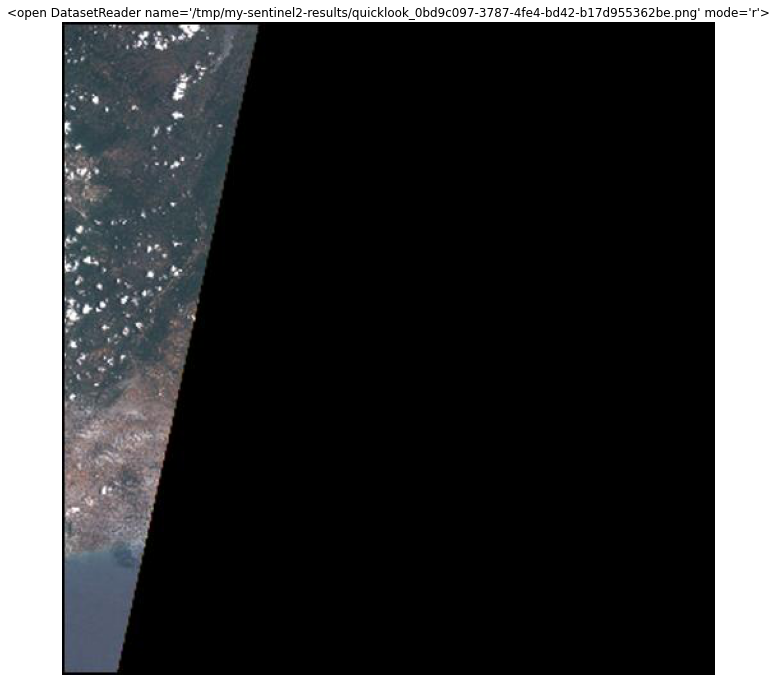

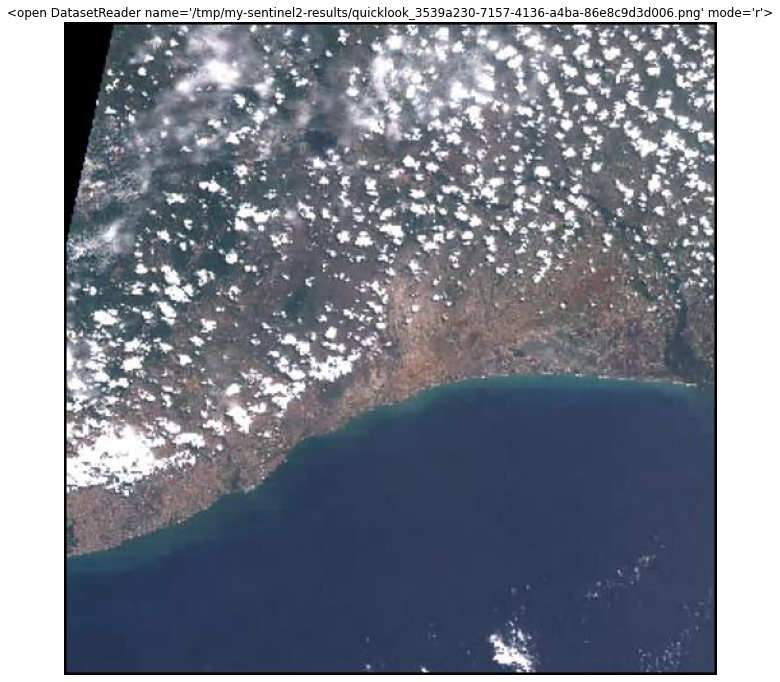

In [95]:
[plt.figure(figsize=(12,12)) and plt.title(s) and plt.axis("off") and plot.show(s) for s in [open(f) for f in sentinel2_quicklooks]];

## Adding the retrieved images to the image list

We already have the scene IDs and acquisition dates.

In [96]:
non_existing_sentinel2

index                                           geometry  \
0      1  POLYGON ((0.69593 5.32864, 0.70242 6.31984, 0....   
1      2  POLYGON ((-0.21289 5.33337, -0.20380 5.37400, ...   

                                     id       acquisitionDate constellation  \
0  3539a230-7157-4136-a4ba-86e8c9d3d006  2020-05-08T10:10:31Z    Sentinel-2   
1  0bd9c097-3787-4fe4-bd42-b17d955362be  2020-04-16T10:15:49Z    Sentinel-2   

   providerName                                         blockNames  \
0  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   
1  sobloo-image  [sobloo-sentinel2-lic-msi-full, sobloo-sentine...   

   cloudCoverage                                 providerProperties  \
0        12.5056  {'timeStamp': 1588932631024, 'uid': '3539a230-...   
1         7.9165  {'timeStamp': 1587032149024, 'uid': '0bd9c097-...   

                                            scene_id  
0  S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_2...  
1  S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_2...

In [97]:
# Append it to the image list CSV file.
non_existing_sentinel2[["acquisitionDate","scene_id"]].to_csv(image_list_file, mode = "a", index = False, header = False)

Inspecting the file.

In [98]:
%%bash
tail -2 data/image_list.csv

2020-05-08T10:10:31Z,S2A_MSIL1C_20200508T101031_N0209_R022_T30NZM_20200508T134553
2020-04-16T10:15:49Z,S2B_MSIL1C_20200416T101549_N0209_R065_T30NZM_20200416T131242


## Done

We can see the two images added to the image list.

## Next steps

Now that we have established the process we can go forth and set a periodic run of this procedure. In UNIX based operating systems [cron](https://en.wikipedia.org/wiki/Cron) allows to schedule the invocation of programs according to pre-defined schedule.
Explaining how to set up cron is out of the scope of this document.

## Support

Any issue you might find or question you might have about this notebook, the UP42 API, the UP42 platform or UP42 in general should be sent to: [support@up42.com](mailto:support@up42.com). 